Twitter Sentiment Analysis
===================

In this project, I would like to focus on **Sentiment Analysis** in a well studied context which is Twitter. Twitter is the most known microblogging website in the world and allow anyone to express its thoughts, opinions, and more, in 140 caracters. Due to the length limit of tweets and the time it takes to send one, tweets tend to reflect what people feel in real time.  

The goal of this project is to be able to **classify if a given tweet is either positive or negative**.

**Dataset**

The dataset contains **1578612 tweets** coming from two sources: Kaggle and Sentiment140. There are four columns that are ItemID, Sentiment, SentimentSource and SentimentText. The Sentiment column correspond to our label class taking a binary value, **0 if the tweet is negative, 1 if the tweet is positive**.  
Tweets have their own terminology which the following (from twitter glossary):  
- **Hashtag**: A hashtag is any word or phrase immediately preceded by the # symbol. When you click on a hashtag, you’ll see other Tweets containing the same keyword or topic.
- **@username**: A username is how you’re identified on Twitter, and is always preceded immediately by the @ symbol. For instance, Katy Perry is @katyperry.
- **MT**: Similar to RT (Retweet), an abbreviation for “Modified Tweet.” Placed before the Retweeted text when users manually retweet a message with modifications, for example shortening a Tweet.
- **Retweet**: RT, A Tweet that you forward to your followers is known as a Retweet. Often used to pass along news or other valuable discoveries on Twitter, Retweets always retain original attribution.
- **Emoticons**: Composed using punctuation and letters, they are used to express emotions concisely, ";) :) ..."

Furthermore, a tweet can also contain **acronyms** ("OMG, WTF, ...") as well as **spelling mistakes**.  
All the **tweets are in english** for simplicity but we can imagine to apply the same concept for other languages.

**Importing The Dataset**


In [131]:
# Import libraries that we are going to use in the project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load our dataset excluding bad lines (format problem)
# The dataset has been cut into three parts to be uploaded on Github
data_1 = pd.read_csv('data/data_1.csv', error_bad_lines=False)
data_2 = pd.read_csv('data/data_2.csv', error_bad_lines=False)
data_3 = pd.read_csv('data/data_3.csv', error_bad_lines=False)
data = pd.concat([data_1, data_2, data_3], axis=0)

# Reindex the data frame and drop the column added by the reset_index function
data.reset_index(drop=True, inplace=True)

# Set max_colwidth to 140 in order to fully see the tweet
pd.set_option('max_colwidth', 140)

# Display the first 10 rows
data.head(10)

ItemID  Sentiment SentimentSource  \
0       1          0    Sentiment140   
1       2          0    Sentiment140   
2       3          1    Sentiment140   
3       4          0    Sentiment140   
4       5          0    Sentiment140   
5       6          0    Sentiment140   
6       7          1    Sentiment140   
7       8          0    Sentiment140   
8       9          1    Sentiment140   
9      10          1    Sentiment140   

                                                                                                                          SentimentText  
0                                                                                              is so sad for my APL friend.............  
1                                                                                                      I missed the New Moon trailer...  
2                                                                                                               omg its already 7:30 :O  
3            .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...  
4                                                                                          i think mi bf is cheating on me!!!       T_T  
5                                                                                                     or i just worry too much?          
6                                                                                                    Juuuuuuuuuuuuuuuuussssst Chillin!!  
7                                                                                Sunny Again        Work Tomorrow  :-|       TV Tonight  
8                                                                                       handed in my uniform today . i miss you already  
9                                                                                              hmmmm.... i wonder how she my number @-)

**From the above dataset we can clearly see the use of(which is of no use in determining the sentiment of a tweet):**  
- acronyms
- sequences of repeated characters
- emoticons
- spelling mistakes
- nouns  

Let's see if our dataset is balanced about the label class sentiment.

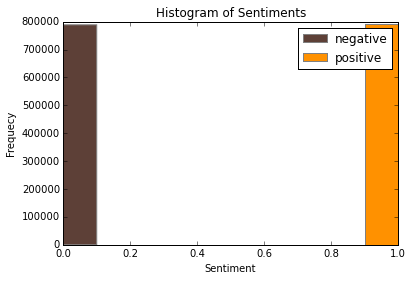

In [2]:
plt.close()
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(data.Sentiment.as_matrix(), edgecolor='gray')

# Set plot title
ax.set_title("Histogram of Sentiments")

# Set x-axis name
ax.set_xlabel("Sentiment")

# Set y-axis name
ax.set_ylabel("Frequecy")

# Select the first patch (a rectangle, object of class matplotlib.patches.Patch)
# corresponding to negative sentiment and color it
patches[0].set_facecolor("#5d4037")
patches[0].set_label("negative")

# Same for the positive sentiment but in another color.
patches[-1].set_facecolor("#ff9100")
patches[-1].set_label("positive")

# Add legend to a plot     
plt.legend()

The dataset seems to be really well-balanced between negative and positive sentiment, let's confirm that by displying numeric values,

In [3]:
data.Sentiment.value_counts()

1    790177
0    788435
dtype: int64

It is important to **check if we have duplicates** in tweets which is something that arise very often because of the RT (Retweet),

In [4]:
# Show duplicated tweets if exist
len(data[data.duplicated('SentimentText')])

0

In [5]:
# Display the number of RT
len(data.SentimentText[data.SentimentText.str.extract('(RT)').notnull()])

13

We are lucky because although there are retweets in our dataset, there is no duplicate which is a good thing when we are going to train our classifier.  

Resources
-------------
In order to facilitate the preproccessing part we have added five resources to the project :
- An **emoticon dictionary** regrouping 132 of the most used emoticons in western with their sentiment, negative or positive.
- An **acronym dictionary** of 5465 acronyms with their translation.
- A **stop word dictionary** corresponding to words which are filtered out before or after processing of natural language data because they are not useful in our case.
- A **positive and negative word dictionaries**.
- A **negative contractions and auxiliaries dictionary** which will be used to detect negation in a given tweet


In [6]:
# Load all of the resources
emoticons = pd.read_csv('data/smileys.csv')
positive_emoticons = emoticons[emoticons.Sentiment == 1]
negative_emoticons = emoticons[emoticons.Sentiment == 0]
emoticons.head(5)

Smiley  Sentiment
0    :-)          1
1     :)          1
2     :D          1
3    :o)          1
4     :]          1

In [7]:
acronyms = pd.read_csv('data/acronyms.csv')
acronyms.tail(5)

Acronym                                   Translation
5459     tomoz                                      tomorrow
5460  gpytfaht  gladly pay you tuesday for a hamburger today
5461      l8rz                                         later
5462      sase               self addressed stamped envelope
5463      bwoc                           big woman on campus

In [8]:
stops = pd.read_csv('data/stopwords.csv')
stops.columns = ['Word']
stops.head(5)

Word
0       able
1      about
2      above
3     abroad
4  according

The resources showed above are mainly used only for the preprocessing part. Another resource that we are going to use is a **lexicon** which corresponds to a list of words where each word is associated with its **polarity**, positive or negative.  
The lexicon is divided into two distinct files, one for positive words, containing **2005 entries** and the other for negative words containing **4782 entries**.

In [9]:
positive_words = pd.read_csv('data/positive-words.csv', sep='\t')
positive_words.columns = ['Word', 'Sentiment']
negative_words = pd.read_csv('data/negative-words.csv', sep='\t')
negative_words.columns = ['Word', 'Sentiment']
positive_words.head(5)

Word  Sentiment
0      abound          1
1     abounds          1
2   abundance          1
3    abundant          1
4  accessable          1

In [10]:
negative_words.head(5)

Word  Sentiment
0     2-faces          0
1    abnormal          0
2     abolish          0
3  abominable          0
4  abominably          0

In [110]:
negation_words = pd.read_csv('data/negation.csv')
negation_words.head(5)

Negation      Tag
0      not  ||not||
1    don't  ||not||
2  doesn't  ||not||
3   aren't  ||not||
4    isn't  ||not||

Preprocessing
-------------
One of the most important parts that is going to be crucial for the learning part is the preprocessing of the data.

To do this we are going to pass our data through these different steps:
- Replace all emoticons by their sentiment polarity ||pos||/||neg|| using the emoticon dictionary.
- Replace all URLs with a tag ||url||.
- Remove Unicode characters.
- Decode HTML entities.
- Reduce all letters to lowercase (We should take care of proper nouns but for simplicity we will lower them as well) (After emoticons because they can use upper case letters)
- Replace all usernames/targets @ with ||target||.
- Replace all acronyms with their translation.
- Replace all negations (e.g: not, no, never) by tag ||not||.
- Replace a sequence of repeated characters by two characters (e.g: "helloooo" = "helloo") to keep the emphasized usage of the word.

#### 1) Replace all emoticons
To replace all emoticons by their corresponding polarity tags ||pos||/||neg|| we use the emoticon dictionary with a regex and check  each tweet if it contains an emoticon.

In [12]:
import re

def make_emoticon_pattern(emoticons):
    pattern = "|".join(map(re.escape, emoticons.Smiley))
    pattern = "(?<=\s)(" + pattern + ")(?=\s)"
    return pattern

def find_with_pattern(pattern, replace=False, tag=None):
    if replace and tag == None:
        raise Exception("Parameter error", "If replace=True you should add the tag by which the pattern will be replaced")
    regex = re.compile(pattern)
    if replace:
        return data.SentimentText.apply(lambda tweet: re.sub(pattern, tag, " " + tweet + " "))
    return data.SentimentText.apply(lambda tweet: re.findall(pattern, " " + tweet + " "))

pos_emoticons_found = find_with_pattern(make_emoticon_pattern(positive_emoticons))
neg_emoticons_found = find_with_pattern(make_emoticon_pattern(negative_emoticons))

nb_pos_emoticons = len(pos_emoticons_found[pos_emoticons_found.map(lambda emoticons : len(emoticons) > 0)])
nb_neg_emoticons = len(neg_emoticons_found[neg_emoticons_found.map(lambda emoticons : len(emoticons) > 0)])
print "Number of positive emoticons: " + str(nb_pos_emoticons) + " Number of negative emoticons: " + str(nb_neg_emoticons)

Number of positive emoticons: 19469 Number of negative emoticons: 11025


In [132]:
data.SentimentText = find_with_pattern(make_emoticon_pattern(positive_emoticons), True, '||pos||')
data.SentimentText = find_with_pattern(make_emoticon_pattern(negative_emoticons), True, '||neg||')
data.head(10)

ItemID  Sentiment SentimentSource  \
0       1          0    Sentiment140   
1       2          0    Sentiment140   
2       3          1    Sentiment140   
3       4          0    Sentiment140   
4       5          0    Sentiment140   
5       6          0    Sentiment140   
6       7          1    Sentiment140   
7       8          0    Sentiment140   
8       9          1    Sentiment140   
9      10          1    Sentiment140   

                                                                                                                              SentimentText  
0                                                                                                is so sad for my APL friend.............    
1                                                                                                        I missed the New Moon trailer...    
2                                                                                                            omg its already 7:30 ||pos||    
3              .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...    
4                                                                                        i think mi bf is cheating on me!!!       ||neg||    
5                                                                                                       or i just worry too much?            
6                                                                                                      Juuuuuuuuuuuuuuuuussssst Chillin!!    
7                                                                              Sunny Again        Work Tomorrow  ||neg||       TV Tonight    
8                                                                                         handed in my uniform today . i miss you already    
9                                                                                            hmmmm.... i wonder how she my number ||pos||

#### 2) Replace all urls
Using the same method as for emoticons, we find all urls in each tweet and replace them by the tag ||url||

In [14]:
pattern_url = re.compile(ur'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

url_found = find_with_pattern(pattern_url)
print "Number of urls: " + str(len(url_found[url_found.map(lambda urls : len(urls) > 0)]))

Number of urls: 73824


In [135]:
data[50:60]

ItemID  Sentiment SentimentSource  \
50      51          0    Sentiment140   
51      52          1    Sentiment140   
52      53          1    Sentiment140   
53      54          0    Sentiment140   
54      55          0    Sentiment140   
55      56          0    Sentiment140   
56      57          0    Sentiment140   
57      58          1    Sentiment140   
58      59          1    Sentiment140   
59      60          0    Sentiment140   

                                                                                                                  SentimentText  
50                                                                                                        baddest day eveer.     
51                                                                bathroom is clean..... now on to more enjoyable tasks......    
52                                                                                                              boom boom pow    
53                                                                                                             but i'm proud.    
54                                                                                                   congrats to helio though    
55      David must be hospitalized for five days end of July (palatine tonsils). I will probably never see Katie in concert.     
56                                                     friends are leaving me 'cause of this stupid love  http://bit.ly/ZoxZC    
57                                                                        go give ur mom a hug right now. http://bit.ly/azFwv    
58                                                                                       Going To See Harry Sunday Happiness     
59                                                                                                Hand quilting it is then...

In [136]:
data.SentimentText = find_with_pattern(pattern_url, True, '||url||')
data[50:60]

ItemID  Sentiment SentimentSource  \
50      51          0    Sentiment140   
51      52          1    Sentiment140   
52      53          1    Sentiment140   
53      54          0    Sentiment140   
54      55          0    Sentiment140   
55      56          0    Sentiment140   
56      57          0    Sentiment140   
57      58          1    Sentiment140   
58      59          1    Sentiment140   
59      60          0    Sentiment140   

                                                                                                                    SentimentText  
50                                                                                                         baddest day eveer.      
51                                                                 bathroom is clean..... now on to more enjoyable tasks......     
52                                                                                                               boom boom pow     
53                                                                                                              but i'm proud.     
54                                                                                                    congrats to helio though     
55       David must be hospitalized for five days end of July (palatine tonsils). I will probably never see Katie in concert.      
56                                                                  friends are leaving me 'cause of this stupid love  ||url||     
57                                                                                     go give ur mom a hug right now. ||url||     
58                                                                                        Going To See Harry Sunday Happiness      
59                                                                                                 Hand quilting it is then...

#### 3) Remove Unicode characteres
We remove unicode characteres since they can cause problems during the tokenization process. We keep only ASCII characteres.

In [138]:
data[1578592:1578602]

ItemID  Sentiment SentimentSource  \
1578592  1578608          1    Sentiment140   
1578593  1578609          1    Sentiment140   
1578594  1578610          0    Sentiment140   
1578595  1578611          0    Sentiment140   
1578596  1578612          1    Sentiment140   
1578597  1578613          1    Sentiment140   
1578598  1578614          1    Sentiment140   
1578599  1578615          0    Sentiment140   
1578600  1578616          1    Sentiment140   
1578601  1578617          1    Sentiment140   

                                                                                                                                       SentimentText  
1578592                                                                                     'Zu SpÃ¤t' by Die Ã„rzte. One of the best bands ever      
1578593                                                                          Zuma bitch tomorrow. Have a wonderful night everyone  goodnight.     
1578594                                                                           zummie's couch tour was amazing....to bad i had to leave early      
1578595     ZuneHD looks great! OLED screen @720p, HDMI, only issue is that I have an iPhone and 2 iPods  . MAKE IT A PHONE and ill buy it @micro...  
1578596                                                                                                   zup there ! learning a new magic trick      
1578597                                                                                                                 zyklonic showers   *evil*     
1578598              ZZ Top â€“ I Thank You ...@hawaiibuzz   .....Thanks for your music and for your ear(s) ...ALL !!!! Have a fab... â™« ||url||     
1578599                                                                                             zzz time. Just wish my love could B nxt 2 me      
1578600                        zzz twitter. good day today. got a lot accomplished. imstorm. got into it w yet another girl. dress shopping tmrw      
1578601                                                                                                           zzz's time, goodnight.  ||url||

In [139]:
def remove_unicode(string):
    try:
        string = string.decode('unicode_escape').encode('ascii','ignore')
    except UnicodeDecodeError:
        pass
    return string

data.SentimentText = data.SentimentText.apply(lambda tweet: remove_unicode(tweet))
data[1578592:1578602]

ItemID  Sentiment SentimentSource  \
1578592  1578608          1    Sentiment140   
1578593  1578609          1    Sentiment140   
1578594  1578610          0    Sentiment140   
1578595  1578611          0    Sentiment140   
1578596  1578612          1    Sentiment140   
1578597  1578613          1    Sentiment140   
1578598  1578614          1    Sentiment140   
1578599  1578615          0    Sentiment140   
1578600  1578616          1    Sentiment140   
1578601  1578617          1    Sentiment140   

                                                                                                                                       SentimentText  
1578592                                                                                         'Zu Spt' by Die rzte. One of the best bands ever      
1578593                                                                          Zuma bitch tomorrow. Have a wonderful night everyone  goodnight.     
1578594                                                                           zummie's couch tour was amazing....to bad i had to leave early      
1578595     ZuneHD looks great! OLED screen @720p, HDMI, only issue is that I have an iPhone and 2 iPods  . MAKE IT A PHONE and ill buy it @micro...  
1578596                                                                                                   zup there ! learning a new magic trick      
1578597                                                                                                                 zyklonic showers   *evil*     
1578598                    ZZ Top  I Thank You ...@hawaiibuzz   .....Thanks for your music and for your ear(s) ...ALL !!!! Have a fab...  ||url||     
1578599                                                                                             zzz time. Just wish my love could B nxt 2 me      
1578600                        zzz twitter. good day today. got a lot accomplished. imstorm. got into it w yet another girl. dress shopping tmrw      
1578601                                                                                                           zzz's time, goodnight.  ||url||

#### 4) Decode HTML entities
Simply decode HTML entities.

In [140]:
data.SentimentText[599982]

'   Cannot get chatroom feature to work.   Updated Java to 10, checked ports, etc. I can see video, but in the &quot;chat,&quot; only a spinning circle.   '

In [141]:
import HTMLParser

html_parser = HTMLParser.HTMLParser()
# Convert tweets in unicode utf-8 to avoid mixing unicode with ascii and causing an error during unescape
data.SentimentText = data.SentimentText.apply(lambda tweet: html_parser.unescape(tweet))
data.SentimentText[599982]

u'   Cannot get chatroom feature to work.   Updated Java to 10, checked ports, etc. I can see video, but in the "chat," only a spinning circle.   '

#### 5) Convert all letters to lower case
This is part is extremely simple, we just transform all tweets to lower case.

In [142]:
data[1578592:1578602]

ItemID  Sentiment SentimentSource  \
1578592  1578608          1    Sentiment140   
1578593  1578609          1    Sentiment140   
1578594  1578610          0    Sentiment140   
1578595  1578611          0    Sentiment140   
1578596  1578612          1    Sentiment140   
1578597  1578613          1    Sentiment140   
1578598  1578614          1    Sentiment140   
1578599  1578615          0    Sentiment140   
1578600  1578616          1    Sentiment140   
1578601  1578617          1    Sentiment140   

                                                                                                                                       SentimentText  
1578592                                                                                         'Zu Spt' by Die rzte. One of the best bands ever      
1578593                                                                          Zuma bitch tomorrow. Have a wonderful night everyone  goodnight.     
1578594                                                                           zummie's couch tour was amazing....to bad i had to leave early      
1578595     ZuneHD looks great! OLED screen @720p, HDMI, only issue is that I have an iPhone and 2 iPods  . MAKE IT A PHONE and ill buy it @micro...  
1578596                                                                                                   zup there ! learning a new magic trick      
1578597                                                                                                                 zyklonic showers   *evil*     
1578598                    ZZ Top  I Thank You ...@hawaiibuzz   .....Thanks for your music and for your ear(s) ...ALL !!!! Have a fab...  ||url||     
1578599                                                                                             zzz time. Just wish my love could B nxt 2 me      
1578600                        zzz twitter. good day today. got a lot accomplished. imstorm. got into it w yet another girl. dress shopping tmrw      
1578601                                                                                                           zzz's time, goodnight.  ||url||

In [143]:
data.SentimentText = data.SentimentText.str.lower()
data.head(10)

ItemID  Sentiment SentimentSource  \
0       1          0    Sentiment140   
1       2          0    Sentiment140   
2       3          1    Sentiment140   
3       4          0    Sentiment140   
4       5          0    Sentiment140   
5       6          0    Sentiment140   
6       7          1    Sentiment140   
7       8          0    Sentiment140   
8       9          1    Sentiment140   
9      10          1    Sentiment140   

                                                                                                                                SentimentText  
0                                                                                                 is so sad for my apl friend.............     
1                                                                                                         i missed the new moon trailer...     
2                                                                                                             omg its already 7:30 ||pos||     
3               .. omgaga. im sooo  im gunna cry. i've been at this dentist since 11.. i was suposed 2 just get a crown put on (30mins)...     
4                                                                                         i think mi bf is cheating on me!!!       ||neg||     
5                                                                                                        or i just worry too much?             
6                                                                                                       juuuuuuuuuuuuuuuuussssst chillin!!     
7                                                                               sunny again        work tomorrow  ||neg||       tv tonight     
8                                                                                          handed in my uniform today . i miss you already     
9                                                                                             hmmmm.... i wonder how she my number ||pos||

#### 6) Replace all usernames/targets @ with the tag ||target||
Since we don't need to take into account usernames in order to determine the sentiment of a tweet we replace them by the tag ||target||.

In [19]:
pattern_usernames = "@\w{1,}"
usernames_found = find_with_pattern(pattern_usernames)
len(data.SentimentText[usernames_found.apply(lambda usernames : len(usernames) > 0)])

735757

In [145]:
data[45:55]

ItemID  Sentiment SentimentSource  \
45      46          1    Sentiment140   
46      47          0    Sentiment140   
47      48          0    Sentiment140   
48      49          0    Sentiment140   
49      50          0    Sentiment140   
50      51          0    Sentiment140   
51      52          1    Sentiment140   
52      53          1    Sentiment140   
53      54          0    Sentiment140   
54      55          0    Sentiment140   

                                                                                                                                  SentimentText  
45                                                                                                         @ginaaa <3 go to the show tonight     
46                                                       @spiral_galaxy @ymptweet  it really makes me sad when i look at muslims reality now     
47                                                                           - all time low shall be my motivation for the rest of the week.     
48       and the entertainment is over, someone complained properly..   @rupturerapture experimental you say? he should experiment with a me...  
49                                                                                another year of lakers .. that's neither magic nor fun ...     
50                                                                                                                       baddest day eveer.      
51                                                                               bathroom is clean..... now on to more enjoyable tasks......     
52                                                                                                                             boom boom pow     
53                                                                                                                            but i'm proud.     
54                                                                                                                  congrats to helio though

In [146]:
data.SentimentText = find_with_pattern(pattern_usernames, True, '||target||')
data[45:55]

ItemID  Sentiment SentimentSource  \
45      46          1    Sentiment140   
46      47          0    Sentiment140   
47      48          0    Sentiment140   
48      49          0    Sentiment140   
49      50          0    Sentiment140   
50      51          0    Sentiment140   
51      52          1    Sentiment140   
52      53          1    Sentiment140   
53      54          0    Sentiment140   
54      55          0    Sentiment140   

                                                                                                                                  SentimentText  
45                                                                                                     ||target|| <3 go to the show tonight      
46                                                         ||target|| ||target||  it really makes me sad when i look at muslims reality now      
47                                                                          - all time low shall be my motivation for the rest of the week.      
48        and the entertainment is over, someone complained properly..   ||target|| experimental you say? he should experiment with a melody...  
49                                                                               another year of lakers .. that's neither magic nor fun ...      
50                                                                                                                      baddest day eveer.       
51                                                                              bathroom is clean..... now on to more enjoyable tasks......      
52                                                                                                                            boom boom pow      
53                                                                                                                           but i'm proud.      
54                                                                                                                 congrats to helio though

#### 7) Replace all acronyms with their translation
Next, we replace all acronyms with their translation using the acronym dictionary.  
At this point, tweets are going to be tokenized by getting rid of the punctuation and using split in order to do the process really fast. We could use **nltk.tokenizer** but it is definitly much much slower (also much more accurate). 


In [148]:
import string
from collections import Counter

# Create a dictionary of acronym which will be used to get translations
acronym_dictionary = dict(zip(acronyms.Acronym, acronyms.Translation))

# Will be used to get rid of the punctuation in tweets (does not include | since we use it for our tokens and ' 
# to take care of don't, can't)
punctuation = '!"#$%&()*+,-./:;<=>?@[\\]^_`{}~'

# Frequency table for acronyms
acronyms_counter = Counter()

# Loop on acronyms to replace those matched in the tweet by the corresponding translations
# Return the tweet and the acronyms used
def acronym_to_translation(tweet, acronyms_counter):
    table = string.maketrans(punctuation," " * len(punctuation))
    tweet = str(tweet).translate(table)
    words = tweet.split()
    new_words = []
    for i, word in enumerate(words):
        if acronym_dictionary.has_key(word):
            acronyms_counter[word] += 1
            new_words.extend(acronym_dictionary[word].split())
        else:
            new_words.append(word)
    return new_words

data.SentimentText = data.SentimentText.apply(lambda tweet: acronym_to_translation(tweet, acronyms_counter))

# Get and display top20 acronyms
top20acronyms = acronyms_counter.most_common(20)
top20acronyms

[('lol', 59000),
 ('u', 54557),
 ('im', 51099),
 ('2', 42645),
 ('gonna', 23716),
 ('4', 18610),
 ('dont', 18363),
 ('wanna', 16357),
 ('ok', 16104),
 ('ur', 12960),
 ('omg', 12178),
 ('n', 10415),
 ('ya', 9948),
 ('gotta', 9243),
 ('r', 8132),
 ('tho', 7696),
 ('tv', 6246),
 ('o', 6002),
 ('kinda', 5953),
 ('pic', 5945)]

In [22]:
# Just to better visualize the top 20 acronym
for i, (acronym, value) in enumerate(top20acronyms):
    print str(i + 1) + ") " + acronym + " => " + acronym_dictionary[acronym] + " : " + str(value) 

1) lol => laughing out loud : 59000
2) u => you : 54557
3) im => instant message : 51099
4) 2 => too : 42645
5) gonna => going to : 23716
6) 4 => for : 18610
7) dont => don't : 18363
8) wanna => want to : 16357
9) ok => okay : 16104
10) ur => your : 12960
11) omg => oh my god : 12178
12) n => and : 10415
13) ya => yeah : 9948
14) gotta => got to : 9243
15) r => are : 8132
16) tho => though : 7696
17) tv => television : 6246
18) o => oh : 6002
19) kinda => kind of : 5953
20) pic => picture : 5945


([<matplotlib.axis.XTick at 0x15be09890>,
 <a list of 20 Text xticklabel objects>)

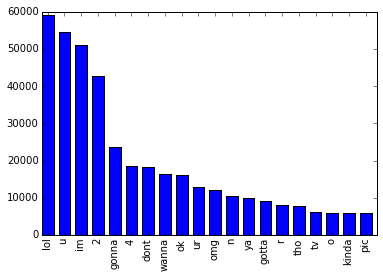

In [23]:
# With a bar plot
plt.close()
top20acronym_keys = [x[0] for x in top20acronyms]
top20acronym_values = [x[1] for x in top20acronyms]
indexes = np.arange(len(top20acronym_keys))
width = 0.7
plt.bar(indexes, top20acronym_values, width)
plt.xticks(indexes + width * 0.5, top20acronym_keys, rotation="vertical")

#### Replace all negations (e.g: not, no, never) by tag ||not||


In [149]:
print data.SentimentText[29]

['i', "didn't", 'realize', 'it', 'was', 'that', 'deep', 'geez', 'give', 'a', 'girl', 'a', 'warning', 'atleast']


In [123]:
# Transform the dataframe into a dictionary
negation_dictionary = dict(zip(negation_words.Negation, negation_words.Tag))

# Find a negation in a tweet and replace it by its tag
def replace_negation(tweet):
    return [negation_dictionary[word] if negation_dictionary.has_key(word) else word for word in tweet]
    
# Apply the function on every tweet
data.SentimentText = data.SentimentText.apply(lambda tweet: replace_negation(tweet))
print data.SentimentText[29]

['i', '||not||', 'realize', 'it', 'was', 'that', 'deep', 'geez', 'give', 'a', 'girl', 'a', 'warning', 'atleast']


####  Replace a sequence of repeated characters by two caracters  


In [151]:
data[1578604:]

ItemID  Sentiment SentimentSource  \
1578604  1578620          1    Sentiment140   
1578605  1578621          1    Sentiment140   
1578606  1578622          0    Sentiment140   
1578607  1578623          1    Sentiment140   
1578608  1578624          1    Sentiment140   
1578609  1578625          0    Sentiment140   
1578610  1578626          0    Sentiment140   
1578611  1578627          0    Sentiment140   

                                                                                         SentimentText  
1578604                                                              [zzzz, no, work, tomorrow, yayyy]  
1578605  [zzzzz, time, tomorrow, will, be, a, busy, day, for, serving, loving, people, love, you, all]  
1578606                                 [zzzzz, want, to, sleep, but, at, sister's, in, laws's, house]  
1578607                                                             [zzzzzz, finally, night, tweeters]  
1578608                                                                 [zzzzzzz, sleep, well, people]  
1578609                                                      [zzzzzzzzzz, wait, no, i, have, homework]  
1578610                                       [zzzzzzzzzzzzz, whatever, what, am, i, doing, up, again]  
1578611                                                                 [zzzzzzzzzzzzzzzzzzz, i, wish]

In [152]:
pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

data.SentimentText = data.SentimentText.apply(lambda tweet: reduce_sequence_tweet(tweet))
data[1578604:]

ItemID  Sentiment SentimentSource  \
1578604  1578620          1    Sentiment140   
1578605  1578621          1    Sentiment140   
1578606  1578622          0    Sentiment140   
1578607  1578623          1    Sentiment140   
1578608  1578624          1    Sentiment140   
1578609  1578625          0    Sentiment140   
1578610  1578626          0    Sentiment140   
1578611  1578627          0    Sentiment140   

                                                                                      SentimentText  
1578604                                                              [zz, no, work, tomorrow, yayy]  
1578605  [zz, time, tomorrow, will, be, a, busy, day, for, serving, loving, people, love, you, all]  
1578606                                 [zz, want, to, sleep, but, at, sister's, in, laws's, house]  
1578607                                                              [zz, finally, night, tweeters]  
1578608                                                                   [zz, sleep, well, people]  
1578609                                                           [zz, wait, no, i, have, homework]  
1578610                                               [zz, whatever, what, am, i, doing, up, again]  
1578611                                                                               [zz, i, wish]

Machine Learning
-------------
After completing the preprocessing part, we can now focus on the machine learning part.  
There are three major methods used to classify a sentence in a given category, in our case, positive(1) or negative(0): SVM, Naive Bayes and N-Gram.  
#### We focus only on the Naive Bayes and N-Gram that are the most common used. 
---------------------

### Naive Bayes

The **Naive Bayes** is a very famous learning algorithm due to its simplicity and its efficiency particularly for text classification. It is based on the application of **Baye's rule** given by:  

$$
P(C=c|D=d)=\frac{P(D=d|C=c)P(C=c)}{P(D=d)}
$$

where $D$ denotes the document and $C$ the category, $d$ and $c$ are instances of $D$ and $C$, $P(D=d)=\sum_{c\in C}P(D=d|C=c)P(C=c)$.We can simplify this expression by,  

$$
P(c|d)=\frac{P(d|c)P(c)}{P(d)}
$$

In our case, a tweet $d$ is represented by a vector of K attributes such as $d=(w_1, w_2, ..., w_K)$. Computing P(d|c) is not trivial and that's why the Naive Bayes introduces the assumption that all of the feature values $w_j$ are independent given the category label $c$. That is, for $i \neq j$, $w_i$ and $w_j$ are conditionally independent given the category label $c$. So the Baye's rule can be rewritten as,

$$
P(c|d) = P(c) \times \frac{\prod_{j=1}^K P(w_j|c)}{P(d)}
$$

Based on this equation, maximum a posterior (MAP) classifier can be constructing by seeking the optimal category which maximizes the posterior $P(c|d)$:  

$$
c* = arg \max_{c \in C} {P(c|d)}\\
c* = arg \max_{c \in C} \left\{P(c) \times \frac{\prod_{j=1}^K P(w_j|c)}{P(d)}\right\}\\
c* = arg \max_{c \in C} \left\{P(c) \times \prod_{j=1}^K P(w_j|c)\right\}
$$

Note that $P(d)$ is removed since it is a constant for every category $c$.  
There are several variants of Naive Bayes classifiers such as:

- the **Multi-variate Bernoulli Model**: Also called binomial model, useful if our feature vectors are binary (e.g 0s and 1s). An application can be text classification with bag of words model where the 0s 1s are "word does not occur in the document" and "word occurs in the document" respectively.  
- the **Multinomial Model**: Typically used for discrete counts. In text classification, we extend the Bernoulli model further by counting the number of times a word $w_i$ appears over the number of words rather than saying 0 or 1 if word occurs or not.  
- the **Gaussian Model**: We assume that features follow a normal distribution. Instead of discrete counts, we have continuous features.

For text classification, the most used considered as the best choice is the **Multinomial Naive Bayes**.  
The **prior distribution $P(c)$** can be used to incorporate additional assumptions about the relative frequencies of classes. It is computed by:  

$$
P(c)=\frac{N_i}{N}
$$

where $N$ is the total number of training tweets and $N_i$ is the number of training tweets in class $c$.  
The **likelihood** $P(w_j|c)$ is usually computed by:  

$$
P(w_j|c)=\frac{1 + count(w_j, c)}{|V| + N_i}
$$

where $count(w_j, c)$ is the number of times that word $w_j$ occurs within the training tweets of class $c$, and $|V|=\sum_jw_j$ the size of the vocabulary. This estimation uses the simplest smoothing method to solve **the zero-probability problem**, that arises when our model encounters a word seen in the test set but not in the training set, **Laplace** or add-one since we use 1 as constant. We will see that Laplace smoothing method is not really effective compared to other smoothing methods used in language models.

#### Baseline

We use the **Multinomial Naive Bayes as learning algorithm with the Laplace smoothing** representing the classic way of doing text classification. Since we need to extract features from our data set of tweets, we use the **bag of words model** to represent it.  
The bag of words model is a simplifying representation of a document where it is represented as a bag of its words without taking consideration of the grammar or word order. In text classification, the frequency of each word is used as a feature for training a classifier.  
For simplicity we use the library scikit-learn.  
Let's first start by dividing our data set into training and test set.

In [89]:
def make_training_test_sets(data):
    
    # Before making the training and test set, we shuffle our data set in order to avoid keeping any order
    data_shuffled = data.iloc[np.random.permutation(len(data))]
    data_shuffled = data_shuffled.reset_index(drop=True)

    # Join the words back into one string separated by space for each tweet
    data_shuffled.SentimentText = data_shuffled.SentimentText.apply(lambda tweet: " ".join(tweet))

    # Separate positive and negative tweets
    positive_tweets = data_shuffled[data_shuffled.Sentiment == 1]
    negative_tweets = data_shuffled[data_shuffled.Sentiment == 0]

    # Cutoff, 3/4 for training of each sentiment and 1/4 of each sentiment for testing
    positive_tweets_cutoff = int(len(positive_tweets) * (3./4.))
    negative_tweets_cutoff = int(len(negative_tweets) * (3./4.))

    # Make the training and test set
    training_tweets = pd.concat([positive_tweets[:positive_tweets_cutoff], negative_tweets[:negative_tweets_cutoff]])
    test_tweets = pd.concat([positive_tweets[positive_tweets_cutoff:], negative_tweets[negative_tweets_cutoff:]])

    # We suffle the training and test set to break the order of tweets based on their sentiment
    training_tweets = training_tweets.iloc[np.random.permutation(len(training_tweets))].reset_index(drop=True)
    test_tweets = test_tweets.iloc[np.random.permutation(len(test_tweets))].reset_index(drop=True)
    
    return training_tweets, test_tweets

training_tweets, test_tweets = make_training_test_sets(data)

print "size of training set: " + str(len(training_tweets))
print "size of test set: " + str(len(test_tweets))


size of training set: 1183958
size of test set: 394654


Once the training set and the test set are created we need a third set of data called the **validation set**.  
It is really useful because it will be **used to validate our model against unseen data and tune the possible parameters of the learning algorithm** to avoid underfitting and overfitting for example.  
We need this validation set because our test set should be used only to verify how well the model will **generalize**. If we use the test set rather than the validation set, our model could be **overly optimistic and twist our results**.
To make the validation set, there are two main options:
- Split the training set into two parts (60%/20%) with a ratio 2:8 where each part contains an equal distribution of example types. We train the classifier with the largest part, and make prediction with the smaller one to validate the model. This technique works well but has the disadvantage of our classifier not getting trained and validated on all examples in the data set (without counting the test set).
- The **K-fold cross-validation**. We split the data set into k parts, hold out one, combine the others and train on them, then validate against the held-out portion. We repeat that process k times (each fold), holding out a different portion each time. Then we average the score measured for each fold to get a more accurate estimation of our model's performance.  

We split the training data into 10 folds and cross validate on them using scikit-learn. The number of K-folds is arbitrary and usually set to 10 it is not a rule. In fact, determine the best K is still an unsolved problem but with lower K: computationally cheaper, less variance, more bias. With large K: computationally expensive, higher variance, lower bias.

In [126]:
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def classify(training_tweets, test_tweets, ngram=(1, 1)):
    # F1 scores for each fold
    scores = []

    # Provides train/test indices to split data in train, validation sets.
    k_fold = KFold(n=len(training_tweets), n_folds=10)

    # Used to convert a collection of text docuements to a matrix of token counts => Bag of words
    count_vectorizer = CountVectorizer(ngram_range=ngram)

    # Confusion matrix with TP/FP/TN/FN
    confusion = np.array([[0, 0], [0, 0]])

    for training_indices, validation_indices in k_fold:
        training_features = count_vectorizer.fit_transform(training_tweets.iloc[training_indices]['SentimentText'].values)
        training_labels = training_tweets.iloc[training_indices]['Sentiment'].values

        validation_features = count_vectorizer.transform(training_tweets.iloc[validation_indices]['SentimentText'].values)
        validation_labels = training_tweets.iloc[validation_indices]['Sentiment'].values

        classifier = MultinomialNB()
        classifier.fit(training_features, training_labels)
        validation_predictions = classifier.predict(validation_features)

        confusion += confusion_matrix(validation_labels, validation_predictions)
        score = f1_score(validation_labels, validation_predictions)
        scores.append(score)
    
    return (sum(scores) / len(scores)), confusion

score, confusion = classify(training_tweets, test_tweets)

print 'Total tweets classified: ' + str(len(training_tweets))
print 'Score: ' +  str(sum(scores) / len(scores))
print 'Confusion matrix:'
print(confusion)

Total tweets classified: 1183958
Score: 0.77653600187
Confusion matrix:
[[465021 126305]
 [136321 456311]]


We get about 0.77 using our baseline.  
We have used two methods to evaluate our classifier, the F1 score and a confusion matrix.  
The **F1 Score** can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. It a **measure of a classifier's accuracy**. The F1 score is given by the following formula,

$$
F1 = \frac{2 \times (precision \times recall)}{(precision + recall)}
$$

where the precision is the number of true positives (the number of items correctly labeled as belonging to the positive class) divided by the total number of elements labeled as belonging to the positive class,

$$
Precision = \frac{TP}{TP+FP}
$$

and the recall is the number of true positives divided by the total number of elements that **actually** belong to the positive class,

$$
Recall = \frac{TP}{TP+FN}
$$

A precision score of 1.0 means that every result retrieved was relevant (but says nothing about whether all relevant elements were retrieved)  whereas a recall score of 1.0 means that all relevant douments were retrieved (but says nothing about how many irrelevant documents were also retrieved).  
There is a **trade-off between precision and recall** where increasing one decrease the other and we usually use measures that combine precision and recall such as F-measure or MCC.  
A **confustion matrix** helps to visualize how the model did during the classification and evaluate its accuracy. In our case we get about 156715 false positive tweets and 139132 false negative tweets. It is "about" because these numbers can vary depending on how we shuffle our data for example.  
We use the F1 score for each fold, which we then average together for **a mean accuracy** on the entire training set.  
Notice that we still didn't use our test set, since we are going to tune our classifier for improving its results.  
One more thing to notice is that we use "count_vectorizer.transform" and not "count_vectorizer.fit_transform" for the validation set since we already learn the vocabulary from the training set and so, we just want its bag of words according to the vocabulary learnt.

Confusion matrix without normalization


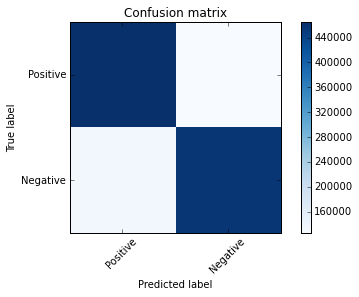

In [91]:
labels = ['Positive', 'Negative']
def plot_confusion_matrix(cm, labels, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
print 'Confusion matrix without normalization'
plt.figure()
plot_confusion_matrix(confusion, labels)

Confusion matrix normalized


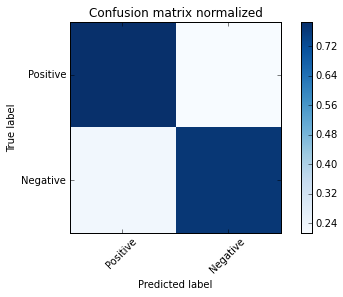

In [92]:
confusion_normalized = confusion.astype(float) / confusion.sum(axis=1)[:, np.newaxis]
print 'Confusion matrix normalized'
plt.figure()
plot_confusion_matrix(confusion_normalized, labels, title='Confusion matrix normalized')

#### Improvements

Now we have our baseline with a accuracy about 0.77, let's try to improve our accuracy score.  

#### Remove all stop words since they should not be useful
Recall that stop words usually refer to the most common words in language such as: "the", "of" and so on, they do not indicate any valuable information about the sentiment of a sentence. 

In [153]:
# We build a word frequency table to see which words are the most used
word_frequency_table = Counter()

def count_word(tweet):
    for word in tweet:
        word_frequency_table[word] += 1
    return tweet

data.SentimentText.map(lambda tweet: count_word(tweet))
word_frequency_table.most_common()[:20]

[('||target||', 780664),
 ('i', 778070),
 ('to', 614954),
 ('the', 538566),
 ('a', 383910),
 ('you', 341545),
 ('my', 336980),
 ('and', 316853),
 ('is', 236393),
 ('for', 236018),
 ('it', 235435),
 ('in', 217350),
 ('of', 192621),
 ('on', 169466),
 ('me', 163900),
 ('so', 158457),
 ('have', 150041),
 ('that', 146260),
 ('out', 143567),
 ('but', 132969)]

The most common words are "i", "to", "the", "a" etc.  
We can also derive word frequency table.

In [95]:
# list of tags
tags = ['||target||', '||url||', '||pos||', '||neg||', '||not||']

# list of tuples representing tags with their corresponding count
tag_counter = [(w, c) for w,c in word_frequency_table.iteritems() if w in tags]

print tag_counter

[('||url||', 75415), ('||target||', 780663), ('||not||', 414873), ('||neg||', 11520), ('||pos||', 20232)]


([<matplotlib.axis.XTick at 0x14adf0d90>,
 <a list of 5 Text xticklabel objects>)

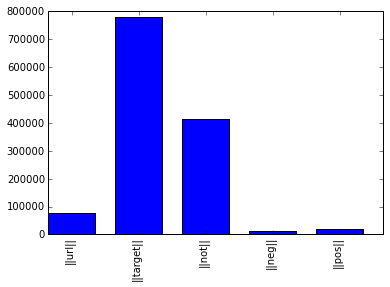

In [96]:
plt.close()
tag_counter_keys = [x[0] for x in tag_counter]
tag_counter_values = [x[1] for x in tag_counter]
indexes = np.arange(len(tag_counter_keys))
width = 0.7
plt.bar(indexes, tag_counter_values, width)
plt.xticks(indexes + width * 0.5, tag_counter_keys, rotation="vertical")

In [97]:
# Transform the dataframe into a dictionary
stopword_dictionary = dict.fromkeys(stops.Word, None)

# Remove stopword from tweets
def remove_stopwords(tweet):
    tweet = [stopword_dictionary[word] if stopword_dictionary.has_key(word) else word for word in tweet]
    return [word for word in tweet if word]

data.SentimentText = data.SentimentText.apply(lambda tweet: remove_stopwords(tweet))
print data.SentimentText.head(20)

0                                                                                              [sad, apl, friend]
1                                                                                         [missed, moon, trailer]
2                                                                                           [god, 7, 30, ||pos||]
3     [omgaga, instant, message, sooo, instant, message, gunna, cry, dentist, 11, suposed, a, crown, put, 30mins]
4                                                                              [mi, boyfriend, cheating, ||neg||]
5                                                                                                         [worry]
6                                                                            [juuuuuuuuuuuuuuuuussssst, relaxing]
7                                                           [sunny, work, tomorrow, ||neg||, television, tonight]
8                                                                                       

In [98]:
# Most common words after deleting stop words
word_frequency_table = Counter()

data.SentimentText.map(lambda tweet: count_word(tweet))
print word_frequency_table.most_common()[:20]

[('||target||', 780663), ('||not||', 414873), ('a', 383910), ('good', 93695), ('day', 84996), ('like', 78959), ('||url||', 75415), ('today', 68974), ('love', 68600), ('laughing', 66411), ('work', 64029), ('loud', 61141), ('time', 57864), ('message', 54279), ('instant', 52222), ('night', 47055), ('home', 39879), ('yeah', 36746), ('tomorrow', 36206), ('great', 34086)]


Now the stop words have been removed, let's see if we have made any improvement.

In [100]:
training_tweets_nosw, test_tweets_nosw = make_training_test_sets(data)
score, confusion = classify(training_tweets_nosw, test_tweets_nosw)
print 'Total tweets classified: ' + str(len(training_tweets_nosw))
print 'Score: ' + str(score)
print 'Confusion matrix:'
print(confusion)

Total tweets classified: 1183958
Score: 0.758623708326
Confusion matrix:
[[437311 154015]
 [136343 456289]]


According to the results, we loose 0.02 points by removing stop words using our list of stop words.

#### Stemming words using NLTK(Natural Language Toolkit)
Stemming is the process by which endings are removed from words in order to remove things like tense or plurality.

In [113]:
import nltk

pstemmer = nltk.PorterStemmer()
def stemming_words(tweet):
    return [pstemmer.stem_word(word) if word not in tags else word for word in tweet]

data.SentimentText = data.SentimentText.apply(lambda tweet: stemming_words(tweet))
print data.SentimentText.head(20)

0                                                                                                             [is, so, sad, for, my, apl, friend]
1                                                                                                              [i, miss, the, new, moon, trailer]
2                                                                                                      [oh, my, god, it, alreadi, 7, 30, ||pos||]
3     [omgaga, instant, messag, soo, instant, messag, gunna, cri, i'v, been, at, thi, dentist, sinc, 11, i, wa, supos, too, just, get, a, crow...
4                                                                                           [i, think, mi, boyfriend, is, cheat, on, me, ||neg||]
5                                                                                                                 [or, i, just, worri, too, much]
6                                                                                                                           

Let's check our accuracy score using stemming.

In [114]:
training_tweets_stems, test_tweets_stems = make_training_test_sets(data)
score, confusion = classify(training_tweets_stems, test_tweets_stems)
print 'Total tweets classified: ' + str(len(training_tweets_stems))
print 'Score: ' + str(score)
print 'Confusion matrix:'
print(confusion)

Total tweets classified: 1183958
Score: 0.773106857186
Confusion matrix:
[[462537 128789]
 [138039 454593]]


As shown above, the stemming process has decreased the result to 0.002, so this process is not useful and does not improve the accuracy score in our case.

### Language Models

On the other hand, **language models are models assigning probabilities to sequence of words**.  
**The quality of a language model can be measured** by the empirical perplexity (or entropy) using:

$$
Perplexity=T\sqrt \frac{1}{P(w_1,...,w_T)}\\
Entropy = log_2 Perplexity
$$

The goal is to minimize the perplexity which is the same as maximizing probability.

An **N-Gram model** is a type of probabilistic language model for predicting the next item in such a sequence in the form of (n - 1) order Markov Model. The **Markov assumption** is the probability of a word depends only on the probability of a limited history.

$$
P(w_i|w_1, ..., w_{i-1}) = P(w_i|w_{i-n+1}, ..., w_{i-1})
$$

A straightforward maximum likelihood estimate of n-gram probabilities from a corpus is given by the observed frequency,

$$
P(w_i|w_{i-n+1}, ..., w_{i-1}) = \frac{count(w_{i-n+1}, ..., w_i)}{count(w_{i-n+1}, ..., w_{i-1})}
$$

There are several kind of n-grams but the most common are the unigram, bigram and trigram.  
The **unigram model** make the assumption that **every word is independent** and so we compute the probability of a sequence using the following formula:  

$$
P(w_1, w_2, ..., w_n) = \prod_i P(w_i)
$$

In the case of the **bigram model** we make the assumption that **a word is dependent of its previous word**:  

$$
P(w_i | w_1, w_2, ..., w_{i-1}) \approx P(w_i | w_{i-1})
$$

To estimate the n-gram probabilities, we need to compute the **Maximum Likelihood Estimates**.  
Unigram:

$$
P(w_i)=\frac{C(w_i)}{N}
$$

Bigram:

$$
P(w_i, w_j)=\frac{count(w_i, w_j)}{N}\\
P(w_j|w_i)=\frac{P(w_i, w_j)}{P(w_i)}=\frac{count(w_i, w_j)}{\sum_wcount(w_i, w)}=\frac{count(w_i, w_j)}{count(w_i)}
$$

Where N is the number of words, C means count, $w_i$ and $w_j$ are words.  
There are two main practical issues:
- We compute everything in **log space** (log probabilities) to avoid underflow (multiplying so many probabilities can lead to too small number) and because adding is faster than multiplying ($p_1\times p_2\times p_3 = log_{p_1} + log_{p_2} + log_{p_3}$)
- We use **smoothing techniques** such as Laplace, Witten-Bell Discounting, Good-Turing Discounting to deal with unseen words in the training occuring in the test set.  

An N-gram language model can be applied to text classification like Naive Bayes model does. A tweet is categorized according to,

$$
c* = arg \max_{c \in C} {P(c|d)}\
$$

and using Baye's rule, this can be rewritten as

$$
c* = arg \max_{c \in C} \{P(c)P(d|c)\}\\
c* = arg \max_{c \in C} \left\{P(c) \times \prod_{i=1}^T P(w_i|w_{i-n+1}, ..., w_{i-1}, c)\right\}\\
c* = arg \max_{c \in C} \left\{P(c) \times \prod_{i=1}^T P_c(w_i|w_{i-n+1}, ..., w_{i-1})\right\}
$$

$P(d|c)$ is the likelihood of $d$ under category $c$ which can be computed by an n-gram language model.  
** An important note is that n-gram classifiers are in fact a generalization of Naive Bayes. A unigram classifier with Laplace smoothing corresponds exactly to the traditional naive Bayes classifier. **  

Since we use bag of words model, meaning we translate this sentence: "I don't like chocolate" into "I", "don't", "like", "chocolate", we could try to use bigram model to take care of negation with "don't like" for this example. We are still going to use Laplace smoothing but we use the parameter ngram_range in CountVectorizer to add the bigram features.


In [129]:
score, confusion = classify(training_tweets, test_tweets, (2, 2))

print 'Total tweets classified: ' + str(len(training_tweets))
print 'Score: ' +  str(score)
print 'Confusion matrix:'
print(confusion)

Total tweets classified: 1183958
Score: 0.784149223247
Confusion matrix:
[[480120 111206]
 [138700 453932]]


Using only bigram features we have slightly improved our accuracy score about 0.01. Based on that we could think of adding unigram and bigram should increase the accuracy score more.

In [130]:
score, confusion = classify(training_tweets, test_tweets, (1, 2))

print 'Total tweets classified: ' + str(len(training_tweets))
print 'Score: ' +  str(score)
print 'Confusion matrix:'
print(confusion)

Total tweets classified: 1183958
Score: 0.795370054626
Confusion matrix:
[[486521 104805]
 [132142 460490]]


And indeed, we increased the accuracy score about 0.02 compared to the baseline. 

---------------------------------------------
**In this project we tried to show the basic way of classifying tweets into positive or
negative category using Naive Bayes as baseline and how language models are related to the
Naive Bayes and can produce better results. We could further improve our classifier by trying to
extract more features from the tweets, trying different kinds of features, tuning the parameters of
the naïve Bayes classifier, or trying another classifier all together.**